<div style="font-size: 28px; margin-bottom: 20px;">
<center>CSE574</center><br>
<center>Handwrittern Digits Classification</center>
</div>

<div style="font-size: 14px; line-height: 20px;">
<center>Isabela Lago</center>
<center>Nathan Margaglio</center>
<center>Timothy Schuler</center>
</div>

# Introduction

For this project, our group is requried to implement a neural network to classify images of handwritten digits.  Specifically, we are given a subset of the MNIST handwritten digits dataset (which consists of black and white, 28x28 images of the the numbers 0 through 9) for which we need to code and train a neural network with a single hidden layer to accurately classify.

In order to do this, we need to implement the forward pass and back propagation algorithms for a neural network, incorporate regularization on the weights to account for overfitting, find and ignore features that don't contribute usable data to our network, and use a validation data set to tune hyper-paramters for the network (number of hidden units and $\lambda$ for regularization).

We also use our code to train a similar neural network on the CelebFaces Attributes Dataset (CelebA) to classify pictures of faces as either having glasses or no glasses.  We then will implement a multi-layered deep neural network, trained on the CelebA set as well, using Tensorflow to compare the affects of the number of layers on execution time and accuracy.

# MNIST Handwritten Digits

For the first part of this project, we will be working with the MNIST handwritten digits dataset.  Our focus is on building a neural network and choosing optimal hyper-parameters for training.

### Choosing Hyper-Parameters for our Neural Network

Once we have implemented the neural network, we need to decide which hyper-parameters to choose in order to find the best results.  In this project, we need to only concern ourselves with the number of hidden units and $\lambda$, the regularization coefficient.  We also remove features from the dataset that do not contribute useful data, i.e., if the nth feature of every training example is the same, then we remove it from each input as it can't contribute to learning to classify different examples.

We chose to test combinations of number of hidden units and $\lambda$ and compare results.  We tested 4, 8, 12, 16, 20, 25, and 50 for the number of hidden layers and 0, 10, 20, 30, 40, 50, and 60 for $\lambda$.  The following our the plots of the resulting accuracy for the MNIST validation data set for each model:

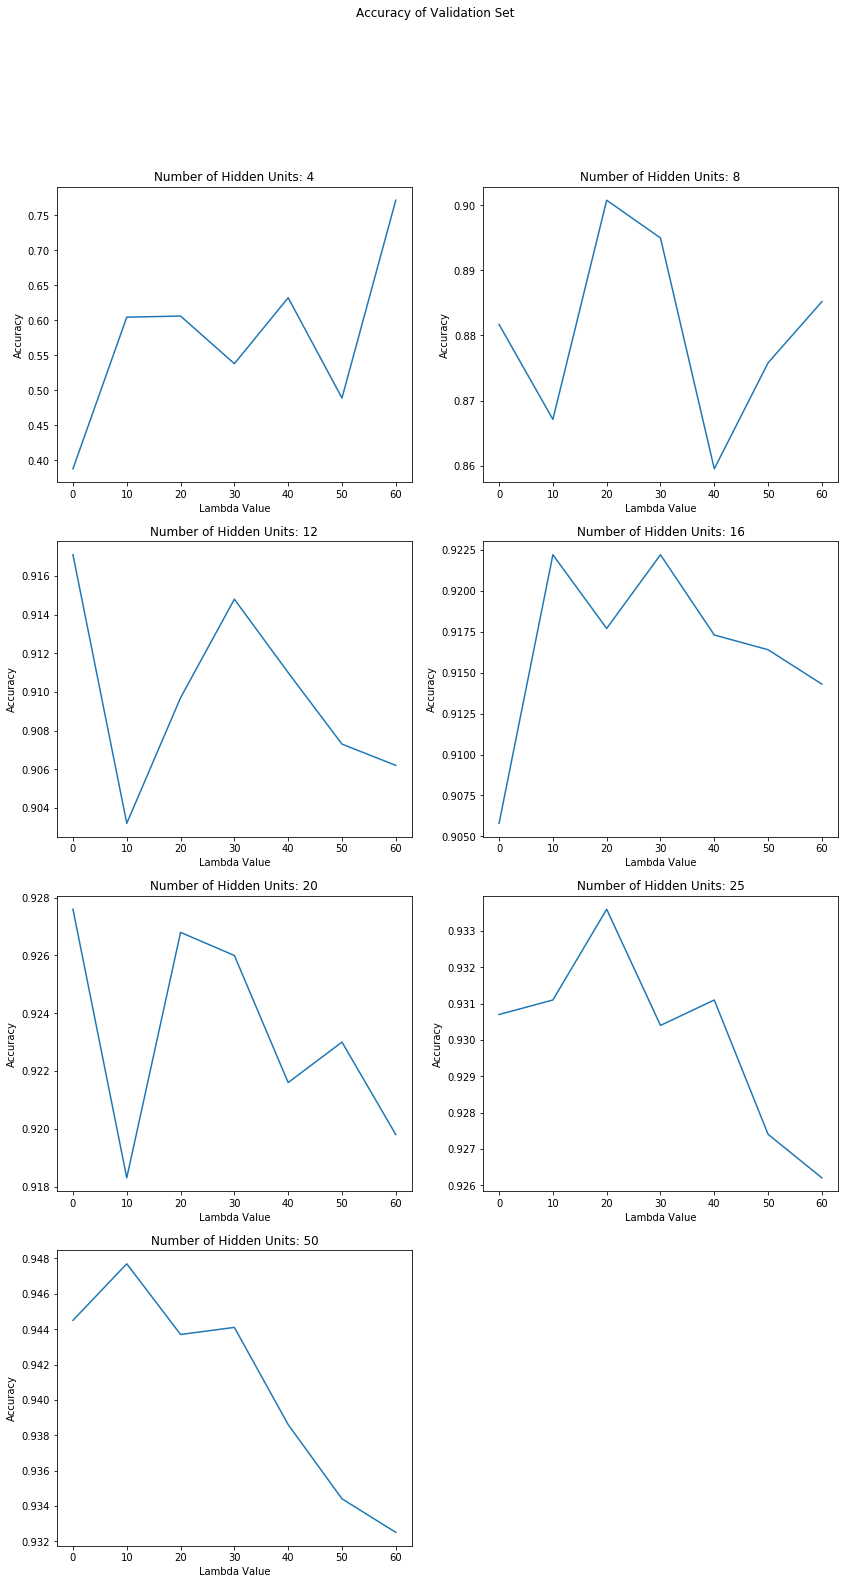

In [36]:
import pickle
import os
import matplotlib.pyplot as plt

pickle_dir = 'logging/pickle_data/'
def get_log_filename(n_hidden, lambdaval):
    return pickle_dir + 'n_{}-l_{}_log.pickle'.format(n_hidden, lambdaval)

n_hiddens = [4, 8, 12, 16, 20, 25, 50]
lambdavals = [0, 10, 20, 30, 40, 50, 60]
logs = {}

for n_hidden in n_hiddens:
    logs[n_hidden] = {}
    for lambdaval in lambdavals:
        with open(get_log_filename(n_hidden, lambdaval), 'rb') as f:
            log = pickle.load(f)
            logs[n_hidden][lambdaval] = log

plt.figure(421, figsize=(14, 25))
for n, n_layers in enumerate(logs):
    val_accs = []
    tra_accs = []
    lambda_vals = []
    for l in logs[n_layers]:
        lambda_vals.append(l)
        val_accs.append(logs[n_layers][l]['val_acc'])
    plt.subplot(4, 2, n+1)
    plt.ylabel('Accuracy')
    plt.xlabel('Lambda Value')
    plt.suptitle('Accuracy of Validation Set')
    plt.title('Number of Hidden Units: ' + str(n_layers))
    plt.plot(lambda_vals, val_accs)

plt.show()

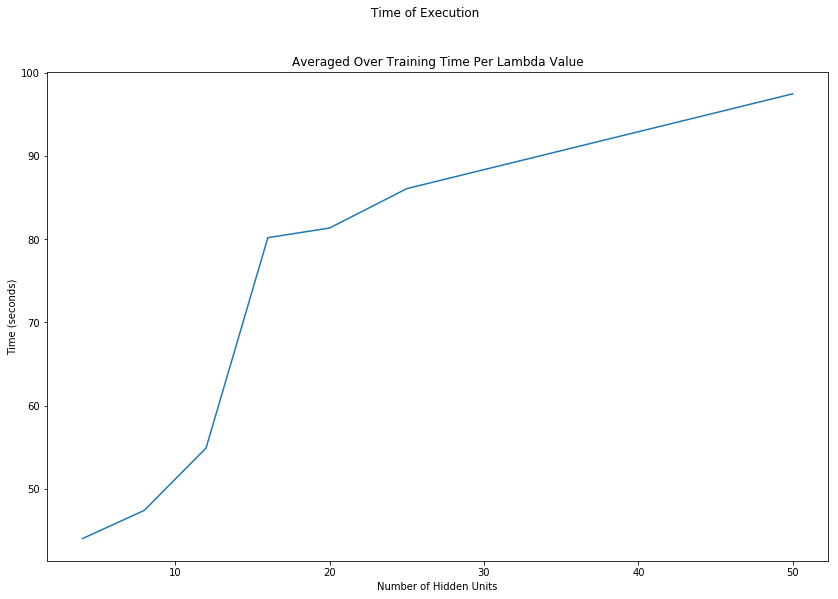

In [35]:
import numpy as np

pickle_dir = 'logging/pickle_data/'
def get_log_filename(n_hidden, lambdaval):
    return pickle_dir + 'n_{}-l_{}_log.pickle'.format(n_hidden, lambdaval)

n_hiddens = [4, 8, 12, 16, 20, 25, 50]
lambdavals = [0, 10, 20, 30, 40, 50, 60]
logs = {}

for n_hidden in n_hiddens:
    logs[n_hidden] = {}
    for lambdaval in lambdavals:
        with open(get_log_filename(n_hidden, lambdaval), 'rb') as f:
            log = pickle.load(f)
            logs[n_hidden][lambdaval] = log

plt.figure(1, figsize=(14, 9))
ave_times = []
for n, n_layers in enumerate(logs):
    times = []
    for l in logs[n_layers]:
        times.append(logs[n_layers][l]['time'])
    ave_times.append(np.mean(times))
        
plt.xlabel('Number of Hidden Units')
plt.ylabel('Time (seconds)')
plt.suptitle('Time of Execution')
plt.title('Averaged Over Training Time Per Lambda Value')

plt.plot(n_hiddens, ave_times)
plt.show()

We notice two things:  as $\lambda$ goes up, accuracy tends to go down, and as number of hidden units goes up, accuracy goes up.  It should also be noted that these values can change depending on what subset of the data we choose for training and validation, however we typically find values similar to these.

Ultimately, it is clear that the more hidden units we have (at least up to 50), the better the accuracy.  For $\lambda$, an optimal value isn't as clear from these plots, but we consider a value of 30 to be generally good given these examples.

The best model we produced used 50 hidden units with a $\lambda$ of 10.  This is what we used in our *params.pickle* file, and, in our tests, yields a training set accuracy of 95.4%, a validation set accuracy of 94.8%, a test set accuracy of 95.0%, all with a training time of about 1 minute and 38 seconds.

### Further Explorations

The scope of this project limits us to only focus on the number of hidden units and $\lambda$ for tuning hyper-paramters of our neural network.  However, there are many more aspects of our model that could be adjusted to find better accuracy, including varying our activation function (we use sigmoid in our implementation, but ReLU is a popular choice), changing the number of layers (which we will discuss next), varying learning rate, and so on.  Even design choices of using convolutional neural networks (which are typically better in terms of accuracy and learning time for images) can be introduced to compare how these implementations perform.

# CelebFaces Attributes Dataset

In the next part of this project, we use the CelebFaces Attributes Dataset.  We focus on comparing how the number of hidden *layers* in a nueral network affects execution time and accuracy.

### Implementing a Single Hidden-Layer Network

First, we use the functions we built in the firt part of this project to build a model that will be trained on the CelebA dataset to classify images of faces with or without glasses.

In order to properly compare the difference in number of layers of the model, we use the number of hidden units present in the code given to us, 256.  For the regularization coefficient $\lambda$, we use the value we found to give good generalized results in the previous part, 30.

For the deep model, we use Tensorflow and the parameters present in the code given to us (so each hidden layer has 256 units).  We train three versions of this model: one with 3 hidden layers, one with 5 hidden layers, and one with 7 hidden layers.

We log the training set and validation set accuracy as well as the time it takes to execute the training:

In [18]:
from datetime import timedelta
with open('logging/pickle_data/face_log.pickle', 'rb') as f:
    face_log = pickle.load(f)

print("Our Neural Network Results")
print("Execution Time: " + str(timedelta(seconds=face_log['time'])))
print("Training Accuracy: " + str(face_log['train_acc']))
print("Validation Accuracy: " + str(face_log['val_acc']))

deep_data = {}
for n_layers in [3, 5, 7]:
    with open('logging/deep_pickle_data/{}_deep_log.pickle'.format(n_layers), 'rb') as f:
        log = pickle.load(f)
        print()
        print("Deep Neural Network Results ({} Layers)".format(n_layers))
        print("Execution Time: " + str(timedelta(seconds=log['time'])))
        print("Training Accuracy: " + str(log['train_acc']))
        print("Validation Accuracy: " + str(log['val_acc']))

Our Neural Network Results
Execution Time: 0:06:48.717797
Training Accuracy: 0.845781990521327
Validation Accuracy: 0.8318949343339587

Deep Neural Network Results (3 Layers)
Execution Time: 0:08:02.704112
Training Accuracy: 0.89398104
Validation Accuracy: 0.78311443

Deep Neural Network Results (5 Layers)
Execution Time: 0:09:08.684698
Training Accuracy: 0.9033175
Validation Accuracy: 0.73846155

Deep Neural Network Results (7 Layers)
Execution Time: 0:10:43.644846
Training Accuracy: 0.9543602
Validation Accuracy: 0.76472795


The results are follow our intuition:

Our neural network takes the least amount of time to train (almost 7 minutes), has the poorest training set accuracy of about 84.6%, but has the best validation set accuracy of about 83.2%.

As the number of layers increase, the execution time increases with 3 hidden layers taking 8 minutes to execute, 5 hidden layers taking 9 minutes, and 7 hidden layers taking almost 11 minutes to execute.  

Also, as the number of layers increase, the training set accuracy increases (from 89.4% at 3 hidden layers, 90.3% at 5 hidden layers, and 95.4% at 7 hidden layers), but the validation set accuracy tends to decrease (from 78.3% at 3 hidden layers, 73.8% at 5 hidden layers, and an increase to 76.5% at 7 hidden layers).

What's happening is that the more hidden layers we introduce, the more closely the neural network can model the function to predict the training data.  However, this is at the cost of computation time (more layers means more calculations in the forward pass and back propagation) as well as overfitting (which is what is most likely causing the increase in training accuracy but decrease in validation accuracy).

### Further Explorations

Adding more layers to a neural network doesn't necessarily mean that we will always see results with better training set accuracy at the cost of validation set accuracy.  If we were to tune the hyper-parameters of the deep neural network (e.g., add regularization), then we might find that we can increase validation accuracy.

Execution time, however, will almost always increase the more complex a model becomes.  We can mitigate increases in time to execute with "smarter" algorithms (such as choosing our initial weights better, choosing better learning rates, etc.), but for the scope of this project, we see that blindly adding layers doesn't necessarily lead to more accurate predictions.